In [4]:

import numpy as np
import pandas as pd

from scipy import stats
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. Seed money와 series a 진출 여부의 상관관계

In [5]:
#Data Import

funding_rounds = pd.read_csv('./crunchbase_1/funding_rounds.csv')
Ranks=pd.read_csv('./Ranks.csv')

In [12]:
# 각 라운드 별 투자금을 데이터 프레임화

angel_amount = funding_rounds[funding_rounds['investment_type'] == 'angel'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
angel_amount.columns = ['org_uuid', 'angel_amount']
angel_amount = angel_amount.groupby('org_uuid').sum()
angel_amount.reset_index(level=['org_uuid'], inplace=True)

seed_amount = funding_rounds[funding_rounds['investment_type'] == 'seed'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
seed_amount.columns = ['org_uuid', 'seed_amount']
seed_amount = seed_amount.groupby('org_uuid').sum()
seed_amount.reset_index(level=['org_uuid'], inplace=True)

pre_seed_amount = funding_rounds[funding_rounds['investment_type'] == 'pre_seed'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
pre_seed_amount.columns = ['org_uuid', 'pre_seed_amount']
pre_seed_amount = pre_seed_amount.groupby('org_uuid').sum()
pre_seed_amount.reset_index(level=['org_uuid'], inplace=True)

# seed money를 계산하여 새로운 데이터 프레임 생성

seed = pd.DataFrame(funding_rounds['org_uuid'].unique(), columns=['org_uuid'])
seed = pd.merge(seed, angel_amount, how='left', on='org_uuid')
seed = pd.merge(seed, seed_amount, how='left', on='org_uuid')
seed = pd.merge(seed, pre_seed_amount, how='left', on='org_uuid')
seed = seed.fillna(0)

seed['seed'] = seed['angel_amount'] + seed['seed_amount'] + seed['pre_seed_amount']


seriesa 진출 여부에 따라 seed money의 평균 계산

LeveneResult(statistic=239.7923961363787, pvalue=5.036594362863649e-54)


t-statistics : 20.98491271249438, p-value : 7.30172280825543e-97




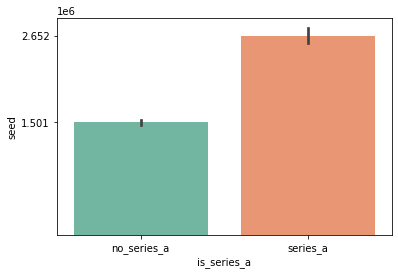

In [13]:
# seed 데이터 프레임에 series a 진출 여부 column 생성

series_a = pd.DataFrame(funding_rounds[funding_rounds['investment_type'] == 'series_a']['org_uuid'].unique(), columns=['org_uuid'])
series_a['is_series_a'] = 1
seed = pd.merge(seed, series_a, how='left', on='org_uuid')
seed['is_series_a'] = seed['is_series_a'].fillna(0)

# seed money 투자를 유치 받은 회사들 중 series a 진출 여부에 따라 데이터 프레임을 분리

yes_a = seed[seed['is_series_a'] == 1]
no_a = seed[seed['is_series_a'] == 0]

only_yes_a = yes_a[yes_a['seed'] != 0]
only_no_a = no_a[no_a['seed'] != 0]

# 등분산성 검정

print(stats.levene(only_yes_a['seed'], only_no_a['seed']))

print('\n')
# 등분산이 아니므로 이분산가정 하에서 t-test 실시

t_stat, p_value = stats.ttest_ind(only_yes_a['seed'], only_no_a['seed'], equal_var=False, alternative="two-sided")
print("t-statistics : {}, p-value : {}".format(t_stat, p_value))

print('\n')

# 유의미한 평균 차이가 존재함을 보임

# 시각화

sns.barplot(data = seed[seed['seed'] != 0], x = 'is_series_a', y = 'seed', estimator = np.mean)
sns.set_palette("Set2")
plt.xticks([0, 1], ['no_series_a', 'series_a'])
plt.yticks(seed[seed['seed'] != 0].groupby('is_series_a').seed.mean())
plt.show()

#2. Seed money와 최종 가치평가의 상관관계

Rank에 따라 seed money의 평균 계산(IPO)

LeveneResult(statistic=4.348750974036406, pvalue=0.005052765491314965)


     Source  ddof1        ddof2          F         p-unc      np2
0  Rank_IPO      3  1145.082579  15.733364  4.961035e-10  0.02597


     A    B        mean(A)        mean(B)           diff             se  \
0  1.0  2.0  499767.987395  125278.052373  374489.935022   75563.233676   
1  1.0  3.0  499767.987395  500534.688650    -766.701255  121514.815283   
2  1.0  4.0  499767.987395  487647.295082   12120.692313  105448.411084   
3  2.0  3.0  125278.052373  500534.688650 -375256.636277  102829.737724   
4  2.0  4.0  125278.052373  487647.295082 -362369.242709   83231.436532   
5  3.0  4.0  500534.688650  487647.295082   12887.393568  126425.947008   

          T           df      pval    hedges  
0  4.955981   620.441685  0.000006  0.329186  
1 -0.006310  1092.441498  1.000000 -0.000354  
2  0.114944  1140.657908  0.999457  0.006569  
3 -3.649301   750.779931  0.001599 -0.199665  
4 -4.353755   831.191279  0.0000

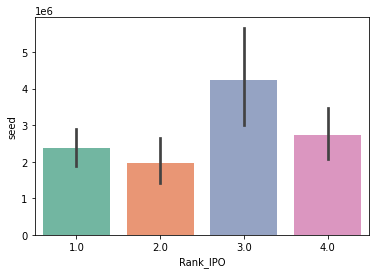

In [15]:
#Seed money와 series a 진출 여부 및 인수합병 또는 기업 공개 때의 기업가치의 상관관계 분석

# rank를 포함한 데이터 프레임 생성

seed_with_rank = pd.merge(seed, Ranks, how='left', on='org_uuid') 

# seed money 투자를 유치한 기업들의 데이터 프레임 생성

yes_only = seed_with_rank[seed_with_rank['seed'] != 0]

# 등분산 검정

ipo1 = yes_only[yes_only['Rank_IPO'] == 1]['seed']
ipo2 = yes_only[yes_only['Rank_IPO'] == 2]['seed']
ipo3 = yes_only[yes_only['Rank_IPO'] == 3]['seed']
ipo4 = yes_only[yes_only['Rank_IPO'] == 4]['seed']

print(stats.levene(ipo1, ipo2, ipo3, ipo4))

print('\n')

# 등분산 가정이 성립하지 않음

# 이분산 가정하에 anova 검정 실시

print(pg.welch_anova(dv = 'seed', between = 'Rank_IPO', data = seed_with_rank) )

print('\n')

# 유의미한 평균 차이 존재

# 사후 분석 실시

print(pg.pairwise_gameshowell(dv = 'seed', between = 'Rank_IPO', data = seed_with_rank))

print('\n')

# 시각화

sns.barplot(data = yes_only, x = 'Rank_IPO', y = 'seed', estimator = np.mean)
sns.set_palette("Set2")
plt.show()

Rank에 따라 seed money의 평균 계산(Acquisition)

LeveneResult(statistic=9.348864957867741, pvalue=4.055670446033205e-06)
     Source  ddof1        ddof2         F    p-unc       np2
0  Rank_Acq      3  3800.227382  5.140578  0.00151  0.050902


     A    B        mean(A)        mean(B)           diff            se  \
0  1.0  2.0  435281.664865  371784.302712   63497.362153  55701.910334   
1  1.0  3.0  435281.664865  329335.454738  105946.210127  56478.830490   
2  1.0  4.0  435281.664865  238324.070620  196957.594245  57708.406859   
3  2.0  3.0  371784.302712  329335.454738   42448.847974  40353.490005   
4  2.0  4.0  371784.302712  238324.070620  133460.232091  42057.176371   
5  3.0  4.0  329335.454738  238324.070620   91011.384118  43080.872356   

          T           df      pval    hedges  
0  1.139949  2124.290136  0.664784  0.044103  
1  1.875857  2253.988512  0.238732  0.068677  
2  3.412979  2382.939291  0.003649  0.124387  
3  1.051925  4141.953568  0.718776  0.032059  
4  3.173305  4010.709109  0.008265  0.098385  
5  

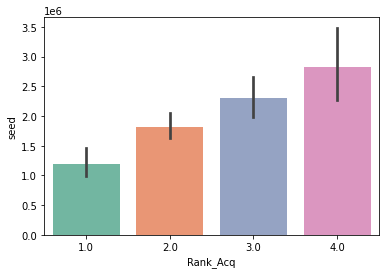

In [16]:
# 등분산 검정

acq1 = yes_only[yes_only['Rank_Acq'] == 1]['seed']
acq2 = yes_only[yes_only['Rank_Acq'] == 2]['seed']
acq3 = yes_only[yes_only['Rank_Acq'] == 3]['seed']
acq4 = yes_only[yes_only['Rank_Acq'] == 4]['seed']

print(stats.levene(acq1, acq2, acq3, acq4))

# 등분산 가정이 성립하지 않음

# 이분산 가정하에 anova 검정 실시

print(pg.welch_anova(dv = 'seed', between = 'Rank_Acq', data = seed_with_rank) )

print('\n')

# 유의미한 평균 차이 존재

# 사후 분석 실시

print(pg.pairwise_gameshowell(dv = 'seed', between = 'Rank_Acq', data = seed_with_rank))

print('\n')

# 시각화

sns.barplot(data = yes_only, x = 'Rank_Acq', y = 'seed', estimator = np.mean)
sns.set_palette("Set2")
plt.show()

In [21]:
# 전처리 결과물을 담을 df 생성
org = pd.DataFrame({'org_uuid': funding_rounds['org_uuid'].unique()})

# Debt Financing, Convertible Note를 통해 투자받은 기록만 확인
lst1=[]
for i in funding_rounds['name']:
    lst1.append('Debt Financing' in i)

lst2=[]
for i in funding_rounds['name']:
    lst2.append('Convertible Note' in i)

debt_firms = funding_rounds[lst1 or lst2]

# debt_firms에 대해서 org_uuids에 대해 groupby해서 summation 구하기.
org_financing =  debt_firms[['org_uuid','raised_amount_usd']].groupby('org_uuid').sum().rename(columns = {'raised_amount_usd':'financing'})

# financing 행 org에 병합
org = pd.merge(org, org_financing, how = 'left', on = 'org_uuid').set_index('org_uuid').fillna(0)

# aver_money
aver_money = funding_rounds.groupby('org_uuid').mean()['raised_amount_usd']

# aver_money행 org에 병합
org = pd.merge(org, aver_money, how = 'left', on = 'org_uuid').fillna(0).rename(columns = {"raised_amount_usd":'aver_money'})

total = funding_rounds.groupby('org_uuid').sum()['raised_amount_usd']
org = pd.merge(org, total, how = 'left', on = 'org_uuid').fillna(0)

# ipo, acquisition, success 여부
ipo_acquisitions = pd.read_csv('./Dataset/by_success.csv',index_col=0).rename(columns = {"uuid":'org_uuid'}).set_index('org_uuid')
org = pd.merge(org,ipo_acquisitions, how='left',on='org_uuid')
org['success'] = org['is_acquisitions'] + org['is_ipos']
org['success'] = org['success'].astype(bool)
org = org[['financing','raised_amount_usd','aver_money','success']]

# organizations의 status 칼럼 추가가
organizations = pd.read_csv('./Dataset/crunchbase_4/organizations.csv').rename(columns = {'uuid':'org_uuid'})
org = pd.merge(org, organizations[['org_uuid','status']], how = 'left', on = 'org_uuid')


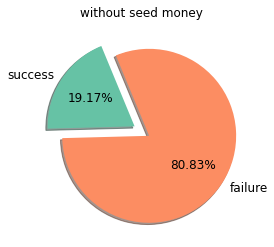

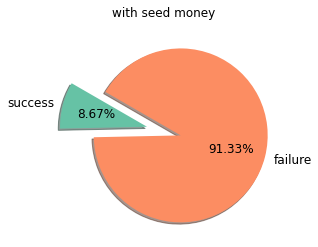

In [22]:
funding_rounds=pd.read_csv('./Dataset/crunchbase_1/funding_rounds.csv',index_col=0)
# angel, seed, pre seed 라운드에서 받은 금액의 합인 seed 칼럼 생성성
angel_amount = funding_rounds[funding_rounds['investment_type'] == 'angel'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
angel_amount.columns = ['org_uuid', 'angel_amount']
angel_amount = angel_amount.groupby('org_uuid').sum()
angel_amount.reset_index(level=['org_uuid'], inplace=True)

seed_amount = funding_rounds[funding_rounds['investment_type'] == 'seed'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
seed_amount.columns = ['org_uuid', 'seed_amount']
seed_amount = seed_amount.groupby('org_uuid').sum()
seed_amount.reset_index(level=['org_uuid'], inplace=True)

pre_seed_amount = funding_rounds[funding_rounds['investment_type'] == 'pre_seed'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
pre_seed_amount.columns = ['org_uuid', 'pre_seed_amount']
pre_seed_amount = pre_seed_amount.groupby('org_uuid').sum()
pre_seed_amount.reset_index(level=['org_uuid'], inplace=True)

seed = pd.DataFrame(funding_rounds['org_uuid'].unique(), columns=['org_uuid'])
seed = pd.merge(seed, angel_amount, how='left', on='org_uuid')
seed = pd.merge(seed, seed_amount, how='left', on='org_uuid')
seed = pd.merge(seed, pre_seed_amount, how='left', on='org_uuid')
seed = seed.fillna(0)

seed['seed'] = seed['angel_amount'] + seed['seed_amount'] + seed['pre_seed_amount']

org = pd.merge(org, seed[['org_uuid', 'seed']], how = 'left', on = 'org_uuid')

# seed가 0인 기업과 그렇지 않은 기업 분리 및 success 비율 시각화
seed0 = org[org['seed']==0]
seed1 = org[org['seed']!=0]

color= sns.set_palette("Set2", 2)
plt.pie([seed0['success'].mean(),1-seed0['success'].mean()], labels = ['success','failure'], explode = (0.1,0.1), shadow = True, startangle = 112.5, textprops = {'fontsize':12},autopct = "%1.2f%%", colors=color)
plt.title('without seed money')
plt.show()

plt.pie([seed1['success'].mean(),1-seed1['success'].mean()], labels = ['success','failure'], explode = (0.2,0.2), shadow = True, startangle = 150, textprops = {'fontsize':12},autopct = "%1.2f%%",colors = color)
plt.title('with seed money')
plt.show()